# Guide on how to use the backtester

In [65]:
# Ensure the project root is in PATH.
import sys
sys.path.append("..")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader

In [188]:
from datamodel import OrderDepth, UserId, TradingState, Order, ConversionObservation, Observation

import numpy as np


CROISSANTS = "CROISSANTS"
DJEMBES = "DJEMBES"
JAMS = "JAMS"
KELP = "KELP"
PICNIC_BASKET1 = "PICNIC_BASKET1"
PICNIC_BASKET2 = "PICNIC_BASKET2"
RAINFOREST_RESIN = "RAINFOREST_RESIN"
SQUID_INK = "SQUID_INK"
VOLCANIC_ROCK = "VOLCANIC_ROCK"
VOLCANIC_ROCK_VOUCHER_10000 = "VOLCANIC_ROCK_VOUCHER_10000"
VOLCANIC_ROCK_VOUCHER_10250 = "VOLCANIC_ROCK_VOUCHER_10250"
VOLCANIC_ROCK_VOUCHER_10500 = "VOLCANIC_ROCK_VOUCHER_10500"
VOLCANIC_ROCK_VOUCHER_9500 = "VOLCANIC_ROCK_VOUCHER_9500"
VOLCANIC_ROCK_VOUCHER_9750 = "VOLCANIC_ROCK_VOUCHER_9750"
MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"

import math
import jsonpickle
import numpy as np
from collections import deque
from typing import List, Dict, Tuple, Any

from datamodel import OrderDepth, TradingState, Order


import math
import jsonpickle
import numpy as np
from collections import deque
from typing import List, Dict, Tuple, Any

from datamodel import OrderDepth, TradingState, Order
from typing import List, Dict, Tuple
import numpy as np
from datamodel import Order, TradingState


VOLCANIC_ROCK = "VOLCANIC_ROCK"
VOLCANIC_ROCK_VOUCHER_10000 = "VOLCANIC_ROCK_VOUCHER_10000"
VOLCANIC_ROCK_VOUCHER_10250 = "VOLCANIC_ROCK_VOUCHER_10250"
VOLCANIC_ROCK_VOUCHER_10500 = "VOLCANIC_ROCK_VOUCHER_10500"
VOLCANIC_ROCK_VOUCHER_9500 = "VOLCANIC_ROCK_VOUCHER_9500"
VOLCANIC_ROCK_VOUCHER_9750 = "VOLCANIC_ROCK_VOUCHER_9750"


class Trader:
    def __init__(self):
        self.products = [
            "VOLCANIC_ROCK",
            "VOLCANIC_ROCK_VOUCHER_9500",
            "VOLCANIC_ROCK_VOUCHER_9750",
            "VOLCANIC_ROCK_VOUCHER_10250",
            "VOLCANIC_ROCK_VOUCHER_10500",
        ]

        self.position_limits = {
            "VOLCANIC_ROCK": 400,
            "VOLCANIC_ROCK_VOUCHER_9500": 200,
            "VOLCANIC_ROCK_VOUCHER_9750": 200,
            "VOLCANIC_ROCK_VOUCHER_10250": 200,
            "VOLCANIC_ROCK_VOUCHER_10500": 200,
        }

        # mean‐reversion params
        self.window = 150

        # edge scheme paramers
        self.entry_edge0 = 0.5
        self.entry_edge_max = 3
        self.exit_edge0 = 0.5
        self.exit_edge_max = 3

        #  runtime
        self.histories = {p: [] for p in self.products}

    def size_function(self, z, edge_0, edge_max, max_position=50):
        z = np.array(z)
        direction = np.where(z > 0, -1, 1)
        abs_z = np.abs(z)
        size = np.where(abs_z <= edge_0, 0, np.where(abs_z >= edge_max, max_position, max_position * ((abs_z - edge_0) / (edge_max - edge_0)) ** 2))
        return direction * size

    def exit_size_function(self, z, edge_0, edge_max, max_position=50):
        # Positive quadratic function with points (0, 0) and (-2, 50)
        if z <= 0:
            if z >= -edge_0:
                return 0
            elif z <= -edge_max:
                return max_position

            a = -max_position / (edge_max - edge_0) ** 2
            return a * (z + edge_max) ** 2 + max_position
        else:
            if z <= edge_0:
                return 0
            elif z >= edge_max:
                return -max_position
            a = max_position / (edge_max - edge_0) ** 2
            return a * (z - edge_max) ** 2 - max_position

    def _get_mid_price(self, state: TradingState, product: str) -> float:
        buy_orders = state.order_depths[product].buy_orders
        sell_orders = state.order_depths[product].sell_orders

        return (max(buy_orders) + min(sell_orders)) / 2

    def _get_bid_ask(self, state: TradingState, product: str):
        buy_orders = state.order_depths[product].buy_orders
        sell_orders = state.order_depths[product].sell_orders

        if len(buy_orders) == 0 or len(sell_orders) == 0:
            return None, None

        return max(buy_orders), min(sell_orders)

    def run(self, state: TradingState):
        result = {}
        conversions = 0

        midprice = self._get_mid_price(state, VOLCANIC_ROCK)
        self.histories[VOLCANIC_ROCK].append(midprice)
        hist = self.histories[VOLCANIC_ROCK]

        # only compute z‐score once we have enough data
        if len(hist) >= self.window:
            window = hist[-self.window :]
            mu = np.mean(window)
            sigma = np.std(window)

            if sigma > 0:
                z = (midprice - mu) / sigma

                for prod in [VOLCANIC_ROCK]:
                    orders = []
                    position = state.position.get(prod, 0)
                    best_bid, best_ask = self._get_bid_ask(state, prod)
                    if best_bid == None or best_ask == None:
                        continue

                    entry_pos = self.size_function(z, self.entry_edge0, self.entry_edge_max, self.position_limits[prod])
                    exit_pos = self.exit_size_function(z, 0, self.exit_edge_max - self.exit_edge0, self.position_limits[prod])

                    # position limits
                    max_sell = abs(-self.position_limits[prod] - position)
                    max_buy = abs(self.position_limits[prod] - position)

                    if z > 0:
                        if position > entry_pos:
                            # sell down to entry pos
                            qty = int(min(abs(entry_pos - position), max_sell))
                            orders.append(Order(prod, best_bid, -qty))
                        elif position < exit_pos:
                            # buy up to exit pos
                            qty = int(min(abs(exit_pos - position), max_buy))
                            orders.append(Order(prod, best_ask, qty))
                    elif z < 0:
                        if position < entry_pos:
                            # buy up to entry pos
                            qty = int(min(abs(entry_pos - position), max_buy))
                            orders.append(Order(prod, best_ask, qty))
                        elif position > exit_pos:
                            # sell down to exit pos
                            qty = int(min(abs(exit_pos - position), max_sell))
                            orders.append(Order(prod, best_bid, -qty))

                    result[prod] = orders

        return result, conversions, state.traderData

In [194]:
from datamodel import OrderDepth, UserId, TradingState, Order
from typing import List
import pandas as pd
import numpy as np

VOLCANIC_ROCK = "VOLCANIC_ROCK"
VOLCANIC_ROCK_VOUCHER_10000 = "VOLCANIC_ROCK_VOUCHER_10000"
VOLCANIC_ROCK_VOUCHER_10250 = "VOLCANIC_ROCK_VOUCHER_10250"
VOLCANIC_ROCK_VOUCHER_10500 = "VOLCANIC_ROCK_VOUCHER_10500"
VOLCANIC_ROCK_VOUCHER_9500 = "VOLCANIC_ROCK_VOUCHER_9500"
VOLCANIC_ROCK_VOUCHER_9750 = "VOLCANIC_ROCK_VOUCHER_9750"


class Rockmaxxer:
    def __init__(self):
        self.products = [
            "VOLCANIC_ROCK",
            "VOLCANIC_ROCK_VOUCHER_9500",
            "VOLCANIC_ROCK_VOUCHER_9750",
            "VOLCANIC_ROCK_VOUCHER_10250",
            "VOLCANIC_ROCK_VOUCHER_10500",
        ]

        self.position_limits = {
            "VOLCANIC_ROCK": 400,
            "VOLCANIC_ROCK_VOUCHER_9500": 200,
            "VOLCANIC_ROCK_VOUCHER_9750": 200,
            "VOLCANIC_ROCK_VOUCHER_10250": 200,
            "VOLCANIC_ROCK_VOUCHER_10500": 200,
        }

        # mean‐reversion params
        self.window = {
            "VOLCANIC_ROCK": 150,
            "VOLCANIC_ROCK_VOUCHER_9500": 75,
            "VOLCANIC_ROCK_VOUCHER_9750": 75,
            "VOLCANIC_ROCK_VOUCHER_10250": 75,
            "VOLCANIC_ROCK_VOUCHER_10500": 75,
        }

        self.z_threshold = {
            "VOLCANIC_ROCK": 1.7,
            "VOLCANIC_ROCK_VOUCHER_9500": 1.7,
            "VOLCANIC_ROCK_VOUCHER_9750": 1.7,
            "VOLCANIC_ROCK_VOUCHER_10250": 1.7,
            "VOLCANIC_ROCK_VOUCHER_10500": 1.7,
        }

        #  runtime
        self.histories = {p: [] for p in self.products}

    def _get_mid_price(self, state: TradingState, product: str) -> float:
        buy_orders = state.order_depths[product].buy_orders
        sell_orders = state.order_depths[product].sell_orders

        return (max(buy_orders) + min(sell_orders)) / 2

    def _get_bid_ask(self, state: TradingState, product: str):
        buy_orders = state.order_depths[product].buy_orders
        sell_orders = state.order_depths[product].sell_orders

        if len(buy_orders) == 0 or len(sell_orders) == 0:
            return None, None

        return max(buy_orders), min(sell_orders)

    def run(self, state: TradingState):
        result = {}
        conversions = 0

        for prod in self.products:
            best_bid, best_ask = self._get_bid_ask(state, prod)
            if best_bid == None or best_ask == None:
                continue

            midprice = self._get_mid_price(state, prod)
            self.histories[prod].append(midprice)
            hist = self.histories[prod]

            # only compute z‐score once we have enough data
            if len(hist) >= self.window[prod]:
                window = hist[-self.window[prod] :]
                mu = np.mean(window)
                sigma = np.std(window)

                if sigma > 0:
                    z = (midprice - mu) / sigma

                    orders = []
                    position = state.position.get(prod, 0)

                    # sell
                    if z > self.z_threshold[prod] and position > -self.position_limits[prod]:
                        qty = self.position_limits[prod] + position
                        orders.append(Order(prod, best_bid, -qty))

                    # buy!
                    elif z < -self.z_threshold[prod] and position < self.position_limits[prod]:
                        qty = self.position_limits[prod] - position
                        orders.append(Order(prod, best_ask, qty))

                    result[prod] = orders

        return result, conversions, state.traderData

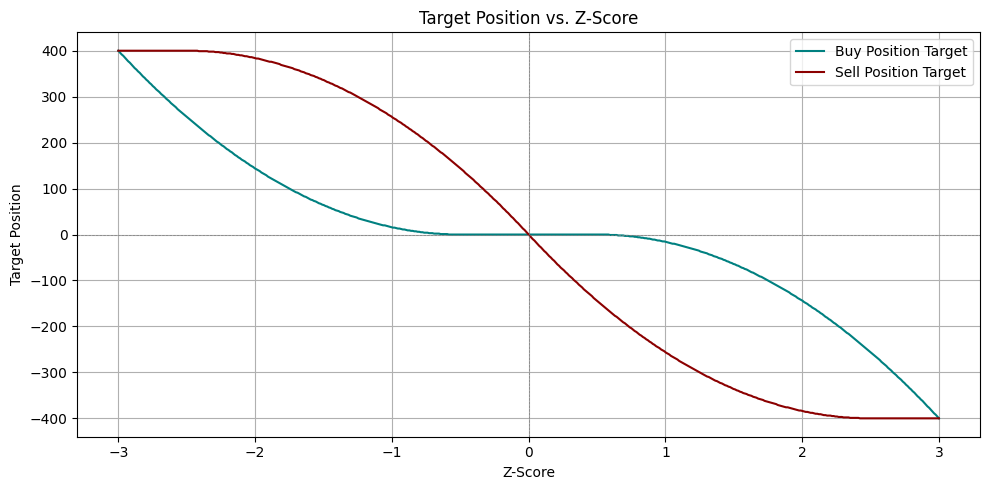

In [185]:
trader = Trader()
# dummy

# Z-score range from -4 to 4
max_position = 400
edge_max = 3

z_vals = pd.Series(np.linspace(-edge_max, edge_max, 500))
k = 4  # Same as in your strategy

edge_0 = 0.5
# Apply leaf functions and scale
buy_positions = np.zeros(len(z_vals))
sell_positions = np.zeros(len(z_vals))


for i in range(len(z_vals)):
    buy_positions[i] = trader.size_function(z_vals[i], edge_0, edge_max, max_position)
    sell_positions[i] = trader.exit_size_function(z_vals[i], 0, edge_max- edge_0, max_position)

#sell_positions = sell_leaf(z_vals / 4, k) * 50

# Round to integer positions for visualization (optional)
buy_positions_rounded = np.round(buy_positions).astype(int)
sell_positions_rounded = np.round(sell_positions).astype(int)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(z_vals, buy_positions_rounded, label='Buy Position Target', color='teal')
plt.plot(z_vals, sell_positions_rounded, label='Sell Position Target', color='darkred')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

plt.title("Target Position vs. Z-Score")
plt.xlabel("Z-Score")
plt.ylabel("Target Position")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
z_vals = pd.Series(np.linspace(-0.007, 0.007, 500))
                    current_row = Trader.volcanic_rock_9500df.iloc[-1]
                    current_iv = current_row['implied_vol']
                    vol_mispricing = current_iv - vol_fair #Measures how high above our fair the current IV is. Could later measure edge based on dollars instead of volpoints.
                    closest_z = z_vals.loc[(z_vals - vol_mispricing).abs().idxmin()]
                    entry_position = np.round(size_function(closest_z, 0, 0.007, 200)).astype(int)
                    exit_position = np.round(exit_size_function(closest_z, 0.0, 0.007, 200)).astype(int)
                    if vol_mispricing > 0: #doing separate cases for when the vol mispricing is above and below 0.
                        if volcanic_rock_9500_position > entry_position: #we are above leaf, need to sell down to it.
                            orders.append(Order(product, current_row["bid_price_1"], -volcanic_rock_9500_position + entry_position))
                        elif volcanic_rock_9500_position < exit_position: #we are below leaf, need to buy up to it.
                            orders.append(Order(product, current_row["ask_price_1"], -volcanic_rock_9500_position + exit_position))
                    elif vol_mispricing < 0:
                        if volcanic_rock_9500_position < entry_position: #We are below leaf, we need to buy up to it.
                            orders.append(Order(product, current_row["ask_price_1"], -volcanic_rock_9500_position + entry_position))
                        elif volcanic_rock_9500_position > exit_position: #We are above leaf, we need to sell down to it.
                            orders.append(Order(product, current_row["bid_price_1"], -volcanic_rock_9500_position + exit_position))

Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [67]:
# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output


market_data_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_2.csv"), sep=";")
market_data_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_3.csv"), sep=";")
market_data_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "prices_round_5_day_4.csv"), sep=";")

trades_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_2.csv"), sep=";")
trades_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_3.csv"), sep=";")
trades_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "trades_round_5_day_4.csv"), sep=";")

observations_round_5_day_2 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_2.csv"), sep=",")
observations_round_5_day_3 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_3.csv"), sep=",")
observations_round_5_day_4 = pd.read_csv(os.path.join("..", "data", "round5", "observations_round_5_day_4.csv"), sep=",")

market_data_round_5_all3days = concatenate_historical_data([market_data_round_5_day_2, market_data_round_5_day_3, market_data_round_5_day_4])
trades_round_5_all3days = concatenate_historical_data([trades_round_5_day_2, trades_round_5_day_3, trades_round_5_day_4])
observations_round_5_all3days = concatenate_historical_data([observations_round_5_day_2, observations_round_5_day_3, observations_round_5_day_4])

Lets run the backtester

In [197]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
    # "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    # "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    # "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    # "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    # "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    # "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    # "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    "VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
    "VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
    "VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    "VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    "VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
    # "MAGNIFICENT_MACARONS": Listing(symbol="MAGNIFICENT_MACARONS", product="MAGNIFICENT_MACARONS", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
    # "CROISSANTS": 250,
    # "DJEMBES": 60,
    # "JAMS": 350,
    # "KELP": 50,
    # "PICNIC_BASKET1": 60,
    # "PICNIC_BASKET2": 100,
    # "RAINFOREST_RESIN": 50,
    # "SQUID_INK": 50,
    "VOLCANIC_ROCK": 400,
    # "VOLCANIC_ROCK_VOUCHER_10000": 200,
    "VOLCANIC_ROCK_VOUCHER_10250": 200,
    "VOLCANIC_ROCK_VOUCHER_10500": 200,
    "VOLCANIC_ROCK_VOUCHER_9500": 200,
    "VOLCANIC_ROCK_VOUCHER_9750": 200,
    # "MAGNIFICENT_MACARONS": 75,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object

# trader = Trader()

# # 6. Instantiate Backtester object
# bt = Backtester(trader, listings, position_limit, market_data_round_5_all3days, trades_round_5_all3days, observations_round_5_all3days)
# bt.run()
# bt.pnl()
import itertools
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

# Define parameter grids for each product separately
product_names = [
    "VOLCANIC_ROCK",
    "VOLCANIC_ROCK_VOUCHER_9500",
    "VOLCANIC_ROCK_VOUCHER_9750",
    "VOLCANIC_ROCK_VOUCHER_10250",
    "VOLCANIC_ROCK_VOUCHER_10500",
]

window_grid = [75, 100, 125, 150]
z_grid = [1.3, 1.5, 1.7, 1.9, 2.1]

# Cartesian product of (product, window, z)
param_list = list(itertools.product(product_names, window_grid, z_grid))


def eval_params_per_product(product, window, z) -> dict:
    trader = Rockmaxxer()

    # override only the current product's settings
    trader.window[product] = int(window)
    trader.z_threshold[product] = float(z)

    bt = Backtester(trader, listings, position_limit, market_data_round_5_day_4, trades_round_5_day_4, observations_round_5_day_4)
    bt.run()
    pnl = bt.pnl()

    return {
        "product": product,
        "window": window,
        "z_threshold": z,
        "spread_total": pnl["spreadcrossing"].get(product, 0.0),
        "midpoint_total": pnl["midpoint"].get(product, 0.0),
    }


# Run evaluations
results = Parallel(n_jobs=-1)(delayed(eval_params_per_product)(prod, win, z) for prod, win, z in tqdm(param_list, desc="Per-product grid search"))

# Convert to DataFrame
df = pd.DataFrame(results)

# Display top result per product
top_per_product = df.sort_values("spread_total", ascending=False).groupby("product").first().reset_index()





Per-product grid search: 100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


In [198]:
# 4) aggregate results into a DataFrame
df = pd.DataFrame(results)

# 5) find best overall config (by spread-crossing PnL)
best = df.loc[df['spread_total'].idxmax()]
print(f"Best config overall:")
print(f"Product: {best['product']}")
print(f"Window: {best['window']}")
print(f"Z threshold: {best['z_threshold']}")
print(f"Spread-PnL: {best['spread_total']:.2f}")
print(f"Midpoint-PnL: {best['midpoint_total']:.2f}")

# 6) (optional) show all top configs by product
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display top N combos across all products
numshow = 20033
print(f"\nTop {numshow} parameter combinations by spread PnL:")
print(df.sort_values('spread_total', ascending=False).head(numshow))

# 7) (optional) group to get the best per product
print("\nBest per product by spread PnL:")
top_per_product = df.sort_values('spread_total', ascending=False).groupby('product').first().reset_index()
print(top_per_product)


Best config overall:
Product: VOLCANIC_ROCK
Window: 150
Z threshold: 1.3
Spread-PnL: 88388.00
Midpoint-PnL: 127879.50

Top 20033 parameter combinations by spread PnL:
                        product  window  z_threshold  spread_total  \
15                VOLCANIC_ROCK     150          1.3       88388.0   
14                VOLCANIC_ROCK     125          2.1       83964.0   
16                VOLCANIC_ROCK     150          1.5       81458.0   
12                VOLCANIC_ROCK     125          1.7       80831.0   
13                VOLCANIC_ROCK     125          1.9       76375.0   
17                VOLCANIC_ROCK     150          1.7       73942.0   
11                VOLCANIC_ROCK     125          1.5       59281.0   
9                 VOLCANIC_ROCK     100          2.1       45369.0   
8                 VOLCANIC_ROCK     100          1.9       43982.0   
19                VOLCANIC_ROCK     150          2.1       41751.0   
30   VOLCANIC_ROCK_VOUCHER_9500     125          1.3       4154

In [204]:
trader = Rockmaxxer()

# trader.mr_window = 150
# trader.mr_z_threshold = 1.7

trader.window[VOLCANIC_ROCK_VOUCHER_9500] = 125
trader.z_threshold[VOLCANIC_ROCK_VOUCHER_9500] = 1.3

# 6. Instantiate Backtester object
bt = Backtester(trader, listings, position_limit, market_data_round_5_all3days, trades_round_5_all3days, observations_round_5_all3days)
bt.run()
bt.pnl()

{'spreadcrossing': {'VOLCANIC_ROCK': 360228.0,
  'VOLCANIC_ROCK_VOUCHER_10250': 12617.0,
  'VOLCANIC_ROCK_VOUCHER_10500': -328.0,
  'VOLCANIC_ROCK_VOUCHER_9500': 150009.0,
  'VOLCANIC_ROCK_VOUCHER_9750': 91652.0,
  'total': 614178.0},
 'midpoint': {'VOLCANIC_ROCK': 455255.0,
  'VOLCANIC_ROCK_VOUCHER_10250': 38812.0,
  'VOLCANIC_ROCK_VOUCHER_10500': 20239.0,
  'VOLCANIC_ROCK_VOUCHER_9500': 186419.5,
  'VOLCANIC_ROCK_VOUCHER_9750': 124434.5,
  'total': 825160.0}}

Available metrics: ['timestamp', 'spreadcrossing_pnl', 'spreadcrossing_final_pnl', 'spreadcrossing_sharpe', 'spreadcrossing_pnl_bps', 'midpoint_pnl', 'midpoint_final_pnl', 'midpoint_sharpe', 'midpoint_pnl_bps', 'position']
Midpoint sharpe: 0.23423113911574633
Spreadcrossing sharpe: 0.18852009466143682


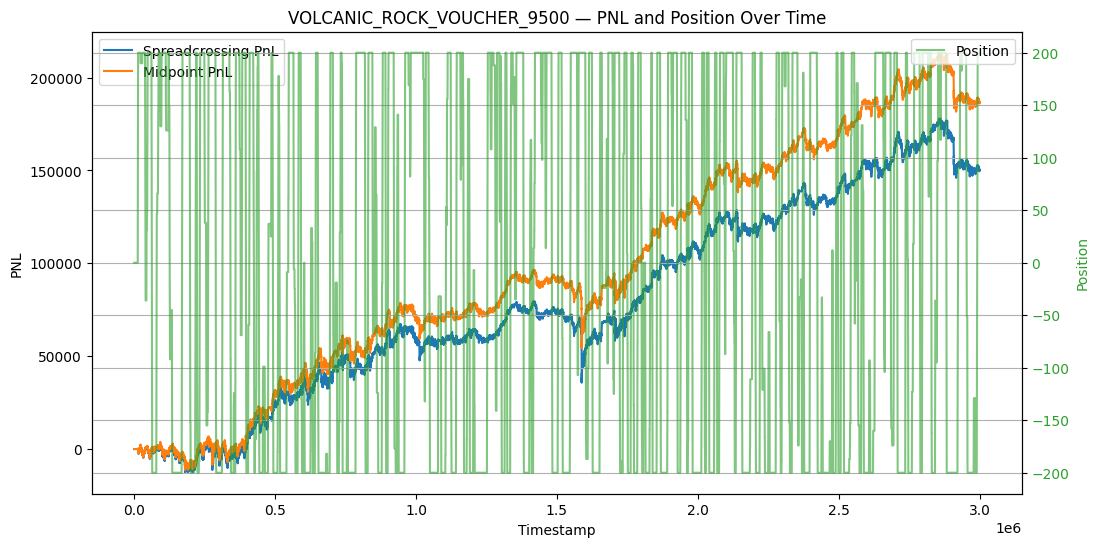

In [205]:
import matplotlib.pyplot as plt

product = VOLCANIC_ROCK_VOUCHER_9500
metrics = bt.calculate_metrics(product)

print(f"Available metrics: {list(metrics.keys())}")

print(f"Midpoint sharpe: {metrics['midpoint_sharpe']}")
print(f"Spreadcrossing sharpe: {metrics['spreadcrossing_sharpe']}")
fig, ax1 = plt.subplots(figsize=(12, 6))

# First y-axis: PnL
ax1.plot(metrics['timestamp'], metrics['spreadcrossing_pnl'], label='Spreadcrossing PnL', color='tab:blue')
ax1.plot(metrics['timestamp'], metrics['midpoint_pnl'], label='Midpoint PnL', color='tab:orange')
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("PNL", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Second y-axis: Position
ax2 = ax1.twinx()
ax2.plot(metrics['timestamp'], metrics['position'], label='Position', color='tab:green', alpha=0.6)
ax2.set_ylabel("Position", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title(f"{product} — PNL and Position Over Time")
plt.grid(True)
plt.show()




Looks quite promising.  

self.spread_tol = 5  # how much we are willing to cross the spread buy to execute  
self.signal_timeout = 2000  # time until we stop moving directionally on a previous signal  
self.signal_volume_threshold = 1  # the threshold of difference in camilla's buy, sell volume to take it as a signal  

Lets try gridsearch to optimise  

In [70]:
# import itertools
# import pandas as pd
# from tqdm import tqdm
# from joblib import Parallel, delayed

# # 1) Define your parameter grid
# param_grid = {
#     "spread_tol":             list(range(0, 11)),            # 0…10
#     "signal_timeout":         list(range(100, 1501, 100)),   # 100,200,…,1500
#     "signal_volume_threshold": list(range(0, 9)),            # 0…8
# }

# # 2) Make every combination
# combos = list(itertools.product(
#     param_grid["spread_tol"],
#     param_grid["signal_timeout"],
#     param_grid["signal_volume_threshold"],
# ))

# # 3) The function to run one backtest
# def eval_params(params):
#     spread_tol, timeout, vol_th = params
    
#     # re‑instantiate a fresh trader & set its params
#     trader = CamillaPabloTrader()
#     trader.spread_tol              = spread_tol
#     trader.signal_timeout          = timeout
#     trader.signal_volume_threshold = vol_th
    
#     # run the backtest
#     bt = Backtester(
#         trader,
#         listings,
#         position_limit,
#         market_data_round_5_all3days,
#         trades_round_5_all3days,
#         observations_round_5_all3days
#     )
#     bt.run()
#     pnl = bt.pnl()
    
#     return {
#         "spread_tol": spread_tol,
#         "signal_timeout": timeout,
#         "signal_volume_threshold": vol_th,
#         "spreadcrossing_pnl": pnl['spreadcrossing'][PICNIC_BASKET2],
#         "midpoint_pnl": pnl['midpoint'][PICNIC_BASKET2]
#     }

# # 4) Kick off the grid‑search in parallel
# results = Parallel(n_jobs=-1)(
#     delayed(eval_params)(params)
#     for params in tqdm(combos, desc="Grid searching", total=len(combos))
# )

# # 5) Collect into a DataFrame & sort by PnL
# df = pd.DataFrame(results)
# df = df.sort_values("midpoint_pnl", ascending=False).reset_index(drop=True)

# # 6) Inspect the top configs
# print(df.head(10))


In [71]:
df = df.sort_values("midpoint_pnl", ascending=False).reset_index(drop=True)

df

NameError: name 'df' is not defined

In [ ]:
th = trades_round_5_day_4.copy()




th = th[th['symbol'] == PICNIC_BASKET2]

np.sum(th['quantity'])


def calc_spread_stats(market_data: pd.DataFrame, product: str):
    md = market_data.copy()
    md = md[md['product'] == product]

    spread = md['ask_price_1'] - md['bid_price_1']

    return np.mean(spread), np.std(spread)



print(f"{CROISSANTS}: {calc_spread_stats(market_data_round_5_day_4, CROISSANTS)}")
print(f"{JAMS}: {calc_spread_stats(market_data_round_5_day_4, JAMS)}")
print(f"{PICNIC_BASKET2}: {calc_spread_stats(market_data_round_5_day_4, PICNIC_BASKET2)}")

print(f"{VOLCANIC_ROCK}: {calc_spread_stats(market_data_round_5_day_4, VOLCANIC_ROCK)}")

CROISSANTS: (1.2093, 0.40680893549675134)
JAMS: (1.615, 0.4865953144040744)
PICNIC_BASKET2: (5.2088, 1.0970882188775886)
VOLCANIC_ROCK: (1.4706, 0.4991348915874345)


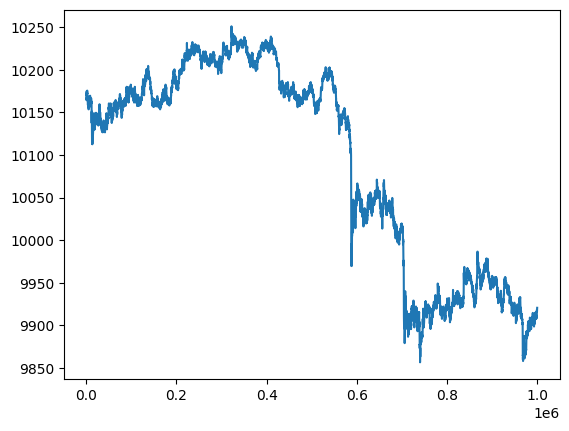

In [147]:
th = trades_round_5_all3days.copy()

party = "Peter"
th = th[(th['buyer'] == party) ^ (th['seller'] == party)]

# np.unique(th['quantity'])
d = th['timestamp'].diff().dropna()
np.mean(d), np.std(d)


# md = market_data_round_5_all3days.copy()
# md = md[md['product'] == KELP]


# spread = md['ask_price_1'] - md['bid_price_1']

md = market_data_round_5_day_3.copy()
md = md[md['product'] == VOLCANIC_ROCK]

plt.plot(md['timestamp'], md['mid_price'])